### ConvLSTM NDVI forecasting using NDVI and LST
- 3 input (3 NDVI and 3 LST) with 3 output (3 NDVI) (distinct timestep)
- NDVI:
  - sourse: MODIS/061/MOD13A2
  - resolution 1km
  - image: 84x65 pixel
- LST:
  - sourse: MODIS/006/MOD11A2
  - resolution 1km
  - image: 84x65 pixel

In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.8 MB/s eta 0:00:00


In [ ]:
import rasterio
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from sklearn.preprocessing import MinMaxScaler

### Preparing NDVI data

In [ ]:
ndvi_path = './NDVI-data-65x84'
ndvi_tif_files = glob.glob(ndvi_path+"/*.tif")

ndvi_tif_files.sort()
len(ndvi_tif_files)

526

In [ ]:
ndvi_tif_files[-3:]

['./NDVI-data-65x84/2022_11_17.tif',
 './NDVI-data-65x84/2022_12_03.tif',
 './NDVI-data-65x84/2022_12_19.tif']

In [ ]:
ndvi_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in ndvi_tif_files]

print(ndvi_data_dates[-5:])
print('\n', len(ndvi_data_dates))

## date indexing

periods = [period for period in range(0, len(ndvi_data_dates), 6)]
ndvi_dataset_dates = []
for i in range(len(ndvi_data_dates)-5):
  period_date = []
  for date in ndvi_data_dates[i:i+6]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  ndvi_dataset_dates.append(period_date_arr)

['2022_10_16', '2022_11_01', '2022_11_17', '2022_12_03', '2022_12_19']

 526


In [ ]:
ndvi_dataset_dates[-3]

array(['2022_08_29', '2022_09_14', '2022_09_30', '2022_10_16',
       '2022_11_01', '2022_11_17'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01',
       '2022_11_17', '2022_12_03'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-1]

array(['2022_09_30', '2022_10_16', '2022_11_01', '2022_11_17',
       '2022_12_03', '2022_12_19'], dtype='<U10')

In [ ]:
crs_list = []
transform_list = []

periods = [period for period in range(0, len(ndvi_tif_files), 6)]
ndvi_dataset = []
for i in range(len(ndvi_tif_files)-5):
  period_data = []
  for file_ in ndvi_tif_files[i:i+6]:
    ndvi_data = rasterio.open(file_)
    ndvi_data_arr = ndvi_data.read(1)
    ndvi_data_crs = ndvi_data.crs  # Get the coordinate reference system (CRS)
    crs_list.append(ndvi_data_crs)
    ndvi_data_transform = ndvi_data.transform # Get the transformation matrix
    transform_list.append(ndvi_data_transform)
    period_data.append(ndvi_data_arr)
  period_data_arr = np.array(period_data)
  ndvi_dataset.append(period_data_arr)

In [ ]:
len(ndvi_dataset)

521

In [ ]:
ndvi_dataset_arr = np.array(ndvi_dataset)
ndvi_dataset_arr.shape

(521, 6, 84, 65)

In [ ]:
samples = ndvi_dataset_arr.shape[0]
time_steps = ndvi_dataset_arr.shape[1]
height, width = ndvi_dataset_arr.shape[2], ndvi_dataset_arr.shape[3]
channels = 1

ndvi_data_raw = ndvi_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [ ]:
# Normalize NDVI values to range [0, 1]
ndvi_scaler = MinMaxScaler()
normalized_ndvi_data = ndvi_scaler.fit_transform(ndvi_data_raw.reshape(-1, 1))
ndvi_data = normalized_ndvi_data.reshape(521, 6, 84, 65, 1)

In [ ]:
print(ndvi_data.min())
print(ndvi_data.max())

0.0
0.9999999999999999


In [ ]:
indexes = np.arange(ndvi_data.shape[0])

train_index = indexes[: int(0.9 * ndvi_data.shape[0])]
val_index = indexes[int(0.9 * ndvi_data.shape[0]) :]

In [ ]:
ndvi_train_dataset = ndvi_data[train_index, :, :, :, :]
ndvi_val_dataset = ndvi_data[val_index, :, :, :, :]

In [ ]:
ndvi_val_dataset.shape

(53, 6, 84, 65, 1)

In [ ]:
def create_shifted_frames(data):
    x = data[:, 0:data.shape[1]-3, :, :, :]
    y = data[:, 3:data.shape[1], :, :, :]
    return x, y


# Apply the processing function to the datasets.
x_train_ndvi, y_train_ndvi = create_shifted_frames(ndvi_train_dataset)
x_val_ndvi, y_val_ndvi = create_shifted_frames(ndvi_val_dataset)

In [ ]:
print("Training Dataset Shapes: " + str(x_train_ndvi.shape) + ", " + str(y_train_ndvi.shape))
print("Validation Dataset Shapes: " + str(x_val_ndvi.shape) + ", " + str(y_val_ndvi.shape))

Training Dataset Shapes: (468, 3, 84, 65, 1), (468, 3, 84, 65, 1)
Validation Dataset Shapes: (53, 3, 84, 65, 1), (53, 3, 84, 65, 1)


### Preparing LST data

In [ ]:
lst_path = './LST-data-1km-65x84'
lst_tif_files = glob.glob(lst_path+"/*.tif")

lst_tif_files.sort()
len(lst_tif_files)

523

In [ ]:
lst_tif_files[-3:]

['./LST-data-1km-65x84/2022_09_30.tif',
 './LST-data-1km-65x84/2022_10_16.tif',
 './LST-data-1km-65x84/2022_11_01.tif']

In [ ]:
lst_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lst_tif_files]

print(lst_data_dates[-5:])
print('\n', len(lst_data_dates))

## date indexing

periods = [period for period in range(0, len(lst_data_dates), 3)]
lst_dataset_dates = []
for i in range(len(lst_data_dates)-2):
  period_date = []
  for date in lst_data_dates[i:i+3]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  lst_dataset_dates.append(period_date_arr)

['2022_08_29', '2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01']

 523


In [ ]:
ndvi_dataset_dates[-3]

array(['2022_08_29', '2022_09_14', '2022_09_30', '2022_10_16',
       '2022_11_01', '2022_11_17'], dtype='<U10')

In [ ]:
lst_dataset_dates[-3]

array(['2022_08_29', '2022_09_14', '2022_09_30'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01',
       '2022_11_17', '2022_12_03'], dtype='<U10')

In [ ]:
lst_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-1]

array(['2022_09_30', '2022_10_16', '2022_11_01', '2022_11_17',
       '2022_12_03', '2022_12_19'], dtype='<U10')

In [ ]:
lst_dataset_dates[-1]

array(['2022_09_30', '2022_10_16', '2022_11_01'], dtype='<U10')

In [ ]:
lst_crs_list = []
lst_transform_list = []

periods = [period for period in range(0, len(lst_tif_files), 3)]
lst_dataset = []
for i in range(len(lst_tif_files)-2):
  period_data = []
  for file_ in lst_tif_files[i:i+3]:
    lst_data = rasterio.open(file_)
    lst_data_arr = lst_data.read(1)
    lst_data_crs = lst_data.crs  # Get the coordinate reference system (CRS)
    lst_crs_list.append(lst_data_crs)
    lst_data_transform = lst_data.transform # Get the transformation matrix
    lst_transform_list.append(lst_data_transform)
    period_data.append(lst_data_arr)
  lst_period_data_arr = np.array(period_data)
  lst_dataset.append(lst_period_data_arr)

In [ ]:
len(lst_dataset)

521

In [ ]:
lst_dataset_arr = np.array(lst_dataset)
lst_dataset_arr.shape

(521, 3, 84, 65)

In [ ]:
(lst_dataset_arr[0][1:]==lst_dataset_arr[1][:-1]).all()

True

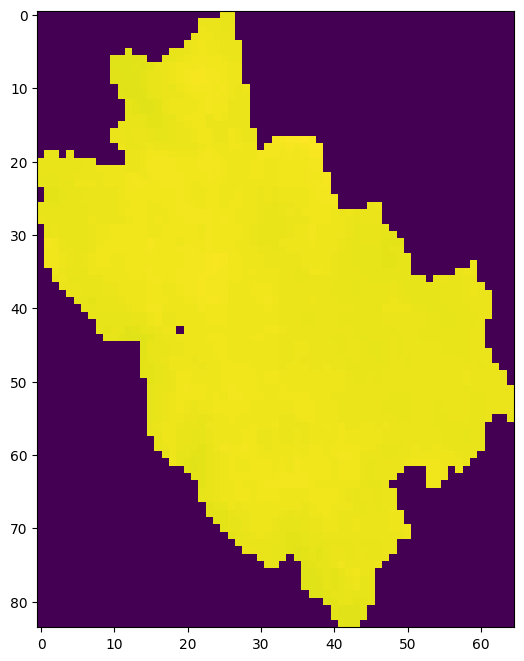

In [ ]:
# Plot the NDVI image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(lst_dataset_arr[3][-1])

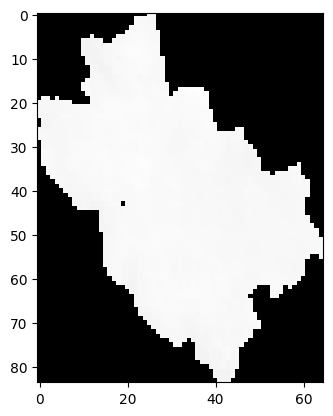

In [ ]:
# Construct a figure for the original and new frames.
plt.imshow(lst_dataset_arr[3][-1], cmap="gray")
# Display the figure.
plt.show()

In [ ]:
print(lst_dataset_arr.min())
print(lst_dataset_arr.max())

0
15772


In [ ]:
lst_dataset_arr.mean()

5261.03868757602

In [ ]:
lst_dataset_arr[0][1].std()

7580.171909689151

In [ ]:
lst_dataset_arr.any()=='NaN'

False

In [ ]:
samples = lst_dataset_arr.shape[0]
time_steps = lst_dataset_arr.shape[1]
height, width = lst_dataset_arr.shape[2], lst_dataset_arr.shape[3]
channels = 1

lst_data_raw = lst_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [ ]:
lst_data_raw.shape

(521, 3, 84, 65, 1)

In [ ]:
lst_scaler = MinMaxScaler()
normalized_lst_data = lst_scaler.fit_transform(lst_data_raw.reshape(-1, 1))
lst_data = normalized_lst_data.reshape(521, 3, 84, 65, 1)

In [ ]:
lst_train_dataset = lst_data[train_index, :, :, :, :]
lst_val_dataset = lst_data[val_index, :, :, :, :]

In [ ]:
(lst_val_dataset[0][-1]==lst_val_dataset[1][-2]).all()

True

In [ ]:
(lst_val_dataset[0][-1]==lst_val_dataset[2][-3]).all()

True

### Modelling

In [ ]:
X_train = [x_train_ndvi, lst_train_dataset]
y_train = y_train_ndvi

X_val =  [x_val_ndvi, lst_val_dataset]
y_val = y_val_ndvi

In [ ]:
# Define the model architecture
input_ndvi = layers.Input(shape=(3, 84, 65, 1))
input_lst = layers.Input(shape=(3, 84, 65, 1))

#convlstm_ndvi = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding='same', return_sequences=True)(input_ndvi)
#convlstm_lst = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding='same', return_sequences=True)(input_lst)

# Merge the ConvLSTM outputs
#merged = layers.Concatenate(axis=-1)([convlstm_lst, convlstm_ndvi])

# Additional convolutional layers to predict NDVI
#conv_out = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same')(merged)

In [ ]:
# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

convlstm_ndvi = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(input_ndvi)
convlstm_lst = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(input_lst)

convlstm_ndvi = layers.BatchNormalization()(convlstm_ndvi)
convlstm_lst = layers.BatchNormalization()(convlstm_lst)

convlstm_ndvi = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(convlstm_ndvi)
convlstm_lst = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(convlstm_lst)

convlstm_ndvi = layers.BatchNormalization()(convlstm_ndvi)
convlstm_lst = layers.BatchNormalization()(convlstm_lst)

convlstm_ndvi = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(convlstm_ndvi)
convlstm_lst = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(convlstm_lst)

# Merge the ConvLSTM outputs
merged = layers.Concatenate(axis=-1)([convlstm_lst, convlstm_ndvi])

conv_out = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same')(merged)

In [ ]:
# Create the model
model = keras.models.Model(inputs=[input_ndvi, input_lst], outputs=conv_out)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 84, 65,   0           []                               
                                1)]                                                               
                                                                                                  
 input_1 (InputLayer)           [(None, 3, 84, 65,   0           []                               
                                1)]                                                               
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)     (None, 3, 84, 65, 6  416256      ['input_2[0][0]']                
                                4)                                                            

In [ ]:
## Model Training

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

## model checkpoint
model_ckpt = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/summer-internship/model-training/ndvi&lst_50epoch_distinct_3to3.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 2

In [ ]:
# Train the model
#model.fit(X_train, y_train, batch_size=2, epochs=20, validation_split=0.2)
# Fit the model to the training data.
model.fit(X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
)

Epoch 1/50
234/234 [==============================] - ETA: 0s - loss: 0.0285
Epoch 1: val_loss improved from inf to 0.10817, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&ls_50epoch_distinct_3to3.h5
234/234 [==============================] - 49s 158ms/step - loss: 0.0285 - val_loss: 0.1082 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - ETA: 0s - loss: 0.0219
Epoch 2: val_loss did not improve from 0.10817
234/234 [==============================] - 34s 143ms/step - loss: 0.0219 - val_loss: 0.1211 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - ETA: 0s - loss: 0.0207
Epoch 3: val_loss improved from 0.10817 to 0.03064, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&ls_50epoch_distinct_3to3.h5
234/234 [==============================] - 34s 147ms/step - loss: 0.0207 - val_loss: 0.0306 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - ETA: 0s - loss: 0.0205
Epoch 4: val_loss di

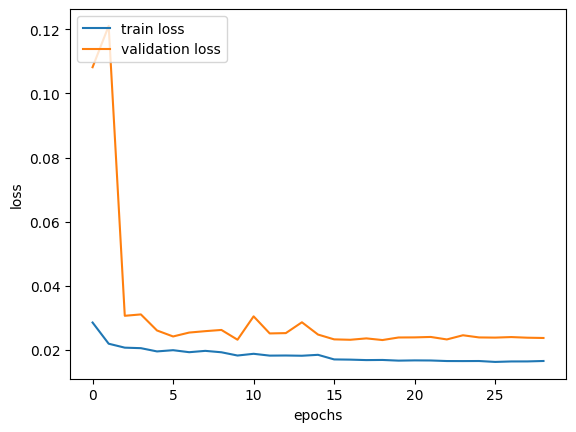

In [ ]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
X_val[0][-1].shape

(53, 3, 84, 65, 1)

In [ ]:
x_example_val = [X_val[0][-1], X_val[1][-1]]
x_example_val[0].shape

(3, 84, 65, 1)

In [ ]:
np.expand_dims(x_example_val[1])

(3, 84, 65, 1)

In [ ]:
x_example_val_0 = np.expand_dims(X_val[0][-1], axis=0)
x_example_val_1 = np.expand_dims(X_val[1][-1], axis=0)

In [ ]:
%%time
y_prediction_ = model.predict([x_example_val_0, x_example_val_1])
y_prediction_.shape

1/1 [==============================] - 1s 1s/step
CPU times: user 1.31 s, sys: 9.02 ms, total: 1.32 s
Wall time: 1.31 s


(1, 3, 84, 65, 1)

In [ ]:
y_prediction = np.squeeze(y_prediction_, axis=0)
y_prediction.shape

(3, 84, 65, 1)

In [ ]:
y_example_val = y_val[-1]
y_example_val.shape

(3, 84, 65, 1)

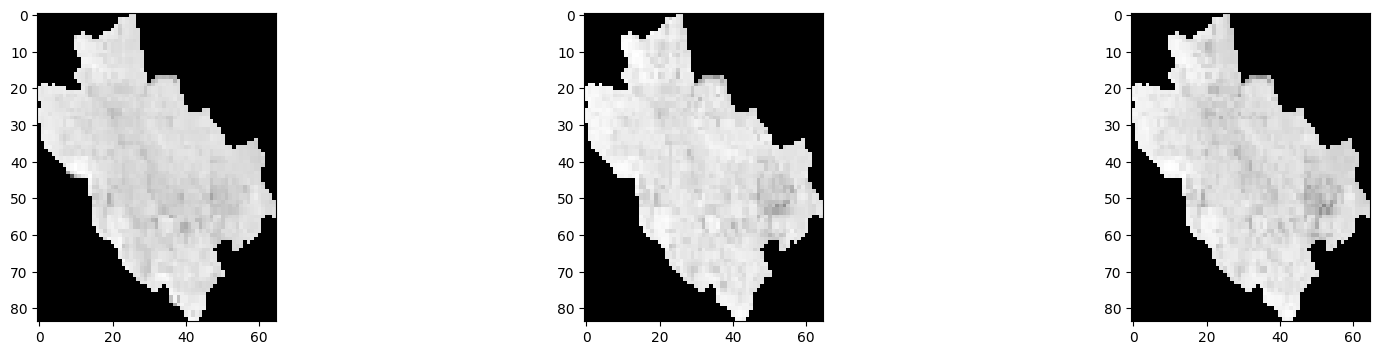

In [ ]:
fig = plt.figure(figsize= (20, 4))
for i in range (3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.imshow(y_example_val[i], cmap="gray")

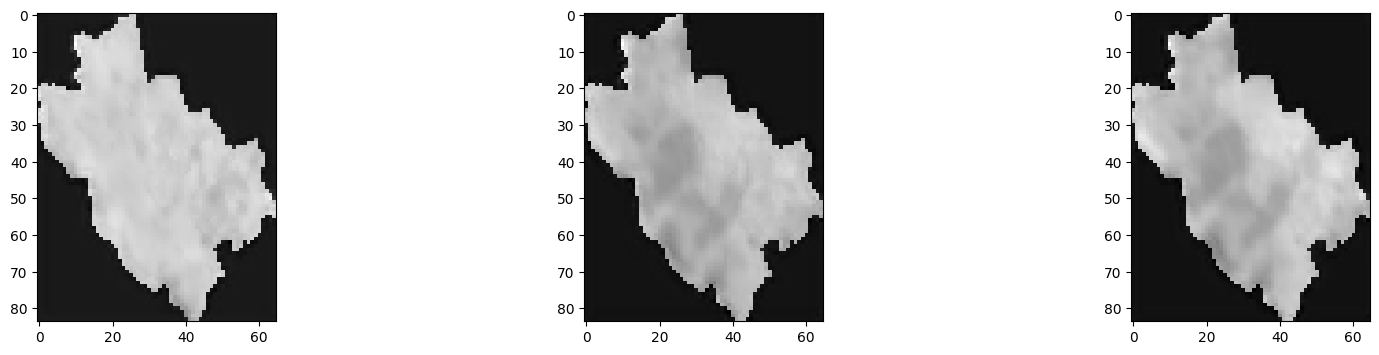

In [ ]:
fig = plt.figure(figsize= (20, 4))
for i in range (3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.imshow(y_prediction[i], cmap="gray")

- Model size: 17.2 MB
- Train loss: 0.0165
- Val loss: 0.02308